<a href="https://colab.research.google.com/github/ddraedd/Decoding-Motor-Intention-from-Neural-Signals-Using-a-Simple-Neural-Network/blob/main/Kalman_Filter_Implementation_for_Neural_Decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import os

In [4]:
mat_file_path = "/content/drive/MyDrive/primate spike data/data_and_scripts/source_data/processed/MT_S1_processed.mat"
mat = scipy.io.loadmat(mat_file_path, squeeze_me=True, struct_as_record=False)
data = mat['Data']

In [15]:
# Kalman Filter Parameters
STATE_DIM = 5  # [pos_x, pos_y, vel_x, vel_y, 1]
DELTA_T = 0.01 # Time step in seconds (assuming 10ms bins from processed data)
TRAIN_TEST_SPLIT_RATIO = 0.8 # 80% for training, 20% for testing

In [5]:
# --- Data Loading and Preprocessing ---

def load_and_preprocess_data(filepath, dt, use_dummy=False):
    """
    Loads and preprocesses data from the specified .mat file using options
    similar to the reference notebook (squeeze_me=True, struct_as_record=False),
    or generates dummy data.

    Args:
        filepath (str): Path to the processed .mat file.
        dt (float): Time step duration in seconds.
        use_dummy (bool): If True, generate dummy data instead of loading.

    Returns:
        tuple: (states, measurements)
               - states: List of numpy arrays, each [num_steps, state_dim] for a trial.
               - measurements: List of numpy arrays, each [num_steps, num_neurons] for a trial.
    """
    if use_dummy:
        print("Generating dummy data...")
        num_trials = 10
        num_steps_per_trial = 100
        num_neurons = 50
        states = []
        measurements = []
        for _ in range(num_trials):
            # Simulate simple linear movement with noise
            pos = np.cumsum(np.random.randn(num_steps_per_trial, 2) * 0.5, axis=0)
            vel = np.gradient(pos, axis=0) / dt
            state_trial = np.hstack([pos, vel, np.ones((num_steps_per_trial, 1))])
            # Simulate neural activity linearly related to state + noise
            C_dummy = np.random.randn(num_neurons, STATE_DIM) * 0.1
            measurement_trial = state_trial @ C_dummy.T + np.random.randn(num_steps_per_trial, num_neurons) * 0.5
            # Apply sqrt transform often used for spike counts
            measurement_trial = np.sqrt(np.maximum(0, measurement_trial)) # Ensure non-negative before sqrt

            states.append(state_trial)
            measurements.append(measurement_trial)
        print("Dummy data generated.")
        return states, measurements

    print(f"Loading data from: {filepath}")
    try:
        # Load using squeeze_me and struct_as_record=False as in the notebook
        mat = scipy.io.loadmat(filepath, squeeze_me=True, struct_as_record=False)
        data = mat['Data'] # Access the 'Data' structure directly
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None, None
    except KeyError:
        print(f"Error: 'Data' structure not found in {filepath}. Check the .mat file format.")
        return None, None
    except Exception as e:
        print(f"An error occurred loading the .mat file: {e}")
        return None, None

    # Extract relevant fields using attribute access (due to struct_as_record=False)
    try:
        # Kinematics: cell array, each cell is [time_bins x 7]
        # Columns: 1:x_pos, 2:y_pos, 3:x_vel, 4:y_vel, 5:x_acc, 6:y_acc, 7:time
        kinematics = data.kinematics

        # Neural Data: cell array, each cell is [neurons x time_bins]
        # Using PMd data as an example, change if needed (e.g., data.neural_data_M1)
        spikes_pmd = data.neural_data_PMd

        num_reaches = kinematics.shape[0]
        print(f"Found {num_reaches} reaches/trials.")

    except AttributeError as e:
        print(f"Error: Missing expected field '{e}' in the 'Data' structure.")
        print("Expected fields like 'kinematics', 'neural_data_PMd'. Check data description and loading options.")
        return None, None

    states = []
    measurements = []

    for i in range(num_reaches):
        # --- Process Kinematics ---
        # Select pos_x, pos_y, vel_x, vel_y
        # Access cell array elements directly
        kin_reach = kinematics[i][:, [0, 1, 2, 3]] # Shape: [num_steps, 4]
        num_steps = kin_reach.shape[0]

        # Add constant offset term
        state_reach = np.hstack([kin_reach, np.ones((num_steps, 1))]) # Shape: [num_steps, 5]

        # --- Process Neural Data ---
        # Transpose to get [num_steps, num_neurons]
        neural_reach = spikes_pmd[i].T # Shape: [num_steps, num_neurons]

        # Optional: Apply square root transform (common for spike counts)
        neural_reach = np.sqrt(np.maximum(0, neural_reach)) # Ensure non-negative counts

        # Ensure consistent number of steps (sometimes kinematics/neural data differ by 1 step)
        min_steps = min(state_reach.shape[0], neural_reach.shape[0])
        if min_steps < 2: # Need at least 2 steps for training estimates
             print(f"Skipping reach {i+1}: Insufficient time steps ({min_steps}).")
             continue

        states.append(state_reach[:min_steps, :])
        measurements.append(neural_reach[:min_steps, :])

    if not states:
        print("Error: No valid reaches processed. Check data or preprocessing steps.")
        return None, None

    print(f"Successfully processed {len(states)} reaches.")
    num_neurons = measurements[0].shape[1]
    print(f"Number of neurons: {num_neurons}")

    return states, measurements


In [8]:
data = load_and_preprocess_data(mat_file_path, 0.01)

Loading data from: /content/drive/MyDrive/primate spike data/data_and_scripts/source_data/processed/MT_S1_processed.mat
Found 419 reaches/trials.
Successfully processed 419 reaches.
Number of neurons: 49


In [9]:

# --- Parameter Estimation ---

def estimate_kalman_params(states_train, measurements_train, dt):
    """
    Estimates Kalman filter parameters A, C, Q, R from training data.

    Args:
        states_train (list): List of state arrays for training trials.
        measurements_train (list): List of measurement arrays for training trials.
        dt (float): Time step duration.

    Returns:
        tuple: (A, C, Q, R) estimated matrices.
    """
    print("Estimating Kalman filter parameters...")
    state_dim = states_train[0].shape[1]
    measurement_dim = measurements_train[0].shape[1]

    # --- Estimate A and Q ---
    # Option 1: Fixed A based on physics (constant velocity model)
    A = np.array([
        [1, 0, dt, 0, 0],
        [0, 1, 0, dt, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]
    ])
    print("Using fixed constant velocity model for A.")

    # Collect state transitions to estimate Q
    all_states_t = []
    all_states_t_plus_1 = []
    for state_trial in states_train:
        all_states_t.append(state_trial[:-1, :]) # x_t
        all_states_t_plus_1.append(state_trial[1:, :]) # x_{t+1}

    X_t = np.vstack(all_states_t)
    X_t_plus_1 = np.vstack(all_states_t_plus_1)

    # Option 2: Estimate A using linear regression (Uncomment to use)
    # print("Estimating A using linear regression...")
    # reg_A = LinearRegression(fit_intercept=False)
    # reg_A.fit(X_t, X_t_plus_1)
    # A = reg_A.coef_
    # print("A estimated via regression.")

    # Calculate process noise residuals w_t = x_{t+1} - A @ x_t
    W = X_t_plus_1 - X_t @ A.T # Note the transpose for matrix multiplication alignment
    Q = np.cov(W.T) # Covariance of residuals
    print("Q estimated.")

    # --- Estimate C and R ---
    # Collect all states (x_t) and corresponding measurements (y_t)
    all_states_for_C = []
    all_measurements_for_C = []
    for i in range(len(states_train)):
        # Use all time steps from each trial
        all_states_for_C.append(states_train[i])
        all_measurements_for_C.append(measurements_train[i])

    X_for_C = np.vstack(all_states_for_C)
    Y_for_C = np.vstack(all_measurements_for_C)

    # Estimate C using linear regression: y_t = C @ x_t
    print("Estimating C using linear regression...")
    reg_C = LinearRegression(fit_intercept=False) # Intercept is handled by the '1' in state vector
    reg_C.fit(X_for_C, Y_for_C)
    C = reg_C.coef_ # Shape: [measurement_dim, state_dim]
    print("C estimated.")

    # Calculate measurement noise residuals v_t = y_t - C @ x_t
    V = Y_for_C - X_for_C @ C.T # Note the transpose
    # Estimate R as covariance of residuals
    # Option 1: Full covariance matrix (can be large and prone to overfitting)
    # R = np.cov(V.T)
    # Option 2: Diagonal R (assumes independent noise across neurons - more robust)
    R = np.diag(np.var(V, axis=0))
    print("R estimated (diagonal).")

    # Regularization (optional but recommended)
    # Add small identity matrix to Q and R to ensure invertibility and stability
    Q += np.eye(state_dim) * 1e-7
    R += np.eye(measurement_dim) * 1e-7

    print("Parameter estimation complete.")
    return A, C, Q, R


In [10]:

# --- Kalman Filter Implementation ---

def kalman_filter(measurements_trial, A, C, Q, R, initial_state, initial_cov):
    """
    Applies the Kalman filter to a single trial of measurements.

    Args:
        measurements_trial (np.array): Measurement vector sequence for the trial [num_steps, num_neurons].
        A (np.array): State transition matrix.
        C (np.array): Measurement matrix.
        Q (np.array): Process noise covariance.
        R (np.array): Measurement noise covariance.
        initial_state (np.array): Initial state estimate (x_0|0).
        initial_cov (np.array): Initial error covariance (P_0|0).

    Returns:
        tuple: (filtered_states, filtered_covariances)
               - filtered_states: Array of state estimates [num_steps, state_dim].
               - filtered_covariances: Array of error covariance estimates [num_steps, state_dim, state_dim].
    """
    num_steps = measurements_trial.shape[0]
    state_dim = A.shape[0]

    # Store estimates
    x_filt = np.zeros((num_steps, state_dim))
    P_filt = np.zeros((num_steps, state_dim, state_dim))

    # Initialization
    x_pred_k_minus_1 = initial_state
    P_pred_k_minus_1 = initial_cov

    for k in range(num_steps):
        # --- Prediction (Time Update) ---
        # x_{k|k-1} = A @ x_{k-1|k-1}
        x_pred = A @ x_pred_k_minus_1
        # P_{k|k-1} = A @ P_{k-1|k-1} @ A.T + Q
        P_pred = A @ P_pred_k_minus_1 @ A.T + Q

        # --- Update (Measurement Update) ---
        y_k = measurements_trial[k, :] # Current measurement

        # Innovation or measurement residual: y_k - C @ x_{k|k-1}
        innovation = y_k - C @ x_pred

        # Innovation covariance: S_k = C @ P_{k|k-1} @ C.T + R
        S_k = C @ P_pred @ C.T + R

        # Optimal Kalman gain: K_k = P_{k|k-1} @ C.T @ inv(S_k)
        try:
            # Use pseudo-inverse for numerical stability if S_k is ill-conditioned
            K_k = P_pred @ C.T @ np.linalg.pinv(S_k)
            # K_k = P_pred @ C.T @ np.linalg.inv(S_k) # Standard inverse
        except np.linalg.LinAlgError:
            print(f"Warning: S_k matrix inversion failed at step {k}. Using pseudo-inverse.")
            K_k = P_pred @ C.T @ np.linalg.pinv(S_k)


        # Updated state estimate: x_{k|k} = x_{k|k-1} + K_k @ innovation
        x_filt_k = x_pred + K_k @ innovation

        # Updated error covariance: P_{k|k} = (I - K_k @ C) @ P_{k|k-1}
        I = np.eye(state_dim)
        P_filt_k = (I - K_k @ C) @ P_pred

        # Store results for this step
        x_filt[k, :] = x_filt_k
        P_filt[k, :, :] = P_filt_k

        # Update for next iteration
        x_pred_k_minus_1 = x_filt_k
        P_pred_k_minus_1 = P_filt_k

    return x_filt, P_filt


In [11]:

# --- Evaluation ---

def evaluate_predictions(true_states_list, predicted_states_list):
    """
    Evaluates the prediction performance using MSE and R2 score.

    Args:
        true_states_list (list): List of true state arrays for test trials.
        predicted_states_list (list): List of predicted state arrays for test trials.

    Returns:
        dict: Dictionary containing evaluation metrics (MSE_x, MSE_y, R2_x, R2_y).
    """
    all_true_pos = np.vstack([s[:, :2] for s in true_states_list]) # Extract true x, y positions
    all_pred_pos = np.vstack([p[:, :2] for p in predicted_states_list]) # Extract predicted x, y positions

    mse_x = mean_squared_error(all_true_pos[:, 0], all_pred_pos[:, 0])
    mse_y = mean_squared_error(all_true_pos[:, 1], all_pred_pos[:, 1])
    r2_x = r2_score(all_true_pos[:, 0], all_pred_pos[:, 0])
    r2_y = r2_score(all_true_pos[:, 1], all_pred_pos[:, 1])

    print("\n--- Evaluation Results ---")
    print(f"Position X - MSE: {mse_x:.4f}, R2: {r2_x:.4f}")
    print(f"Position Y - MSE: {mse_y:.4f}, R2: {r2_y:.4f}")

    return {'MSE_x': mse_x, 'MSE_y': mse_y, 'R2_x': r2_x, 'R2_y': r2_y}

# --- Plotting ---

def plot_trajectory(true_states_trial, predicted_states_trial, trial_index):
    """ Plots the true vs predicted trajectory for a single trial. """
    plt.figure(figsize=(8, 8))
    plt.plot(true_states_trial[:, 0], true_states_trial[:, 1], 'b-', label='True Trajectory')
    plt.plot(predicted_states_trial[:, 0], predicted_states_trial[:, 1], 'r--', label='Predicted Trajectory')
    plt.scatter(true_states_trial[0, 0], true_states_trial[0, 1], c='blue', marker='o', s=100, label='Start (True)')
    plt.scatter(predicted_states_trial[0, 0], predicted_states_trial[0, 1], c='red', marker='x', s=100, label='Start (Pred)')
    plt.xlabel("X Position (cm)")
    plt.ylabel("Y Position (cm)")
    plt.title(f"Kalman Filter Prediction - Trial {trial_index + 1}")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()


Loading data from: /content/drive/MyDrive/primate spike data/data_and_scripts/source_data/processed/MT_S1_processed.mat
Found 419 reaches/trials.
Successfully processed 419 reaches.
Number of neurons: 49

Data split: 335 training trials, 84 testing trials.
Estimating Kalman filter parameters...
Using fixed constant velocity model for A.
Q estimated.
Estimating C using linear regression...
C estimated.
R estimated (diagonal).
Parameter estimation complete.

Running Kalman filter on test trials...
Filtering trial 1/84...
Filtering trial 2/84...
Filtering trial 3/84...
Filtering trial 4/84...
Filtering trial 5/84...
Filtering trial 6/84...
Filtering trial 7/84...
Filtering trial 8/84...
Filtering trial 9/84...
Filtering trial 10/84...
Filtering trial 11/84...
Filtering trial 12/84...
Filtering trial 13/84...
Filtering trial 14/84...
Filtering trial 15/84...
Filtering trial 16/84...
Filtering trial 17/84...
Filtering trial 18/84...
Filtering trial 19/84...
Filtering trial 20/84...
Filterin

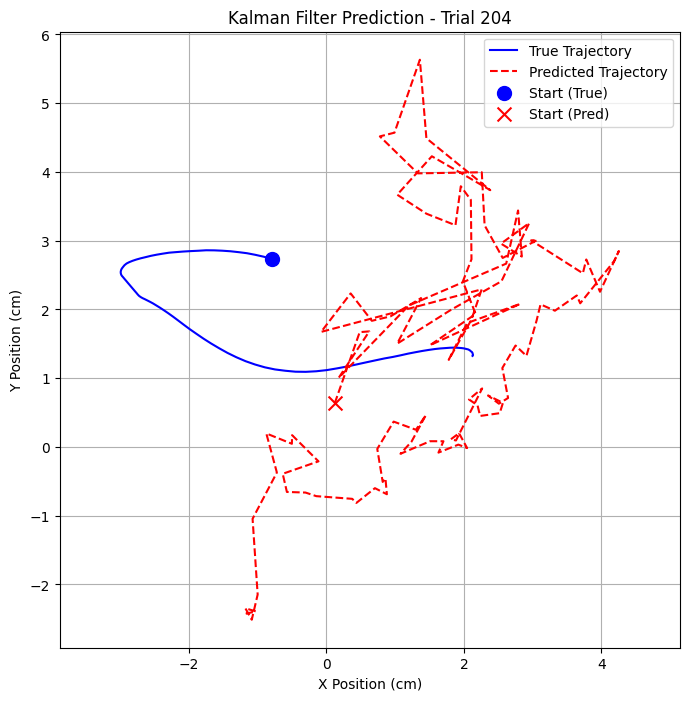

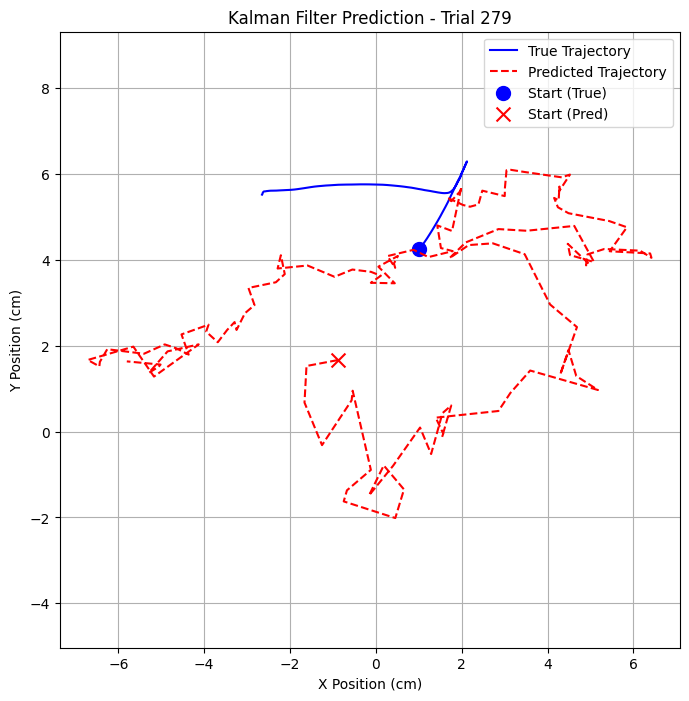

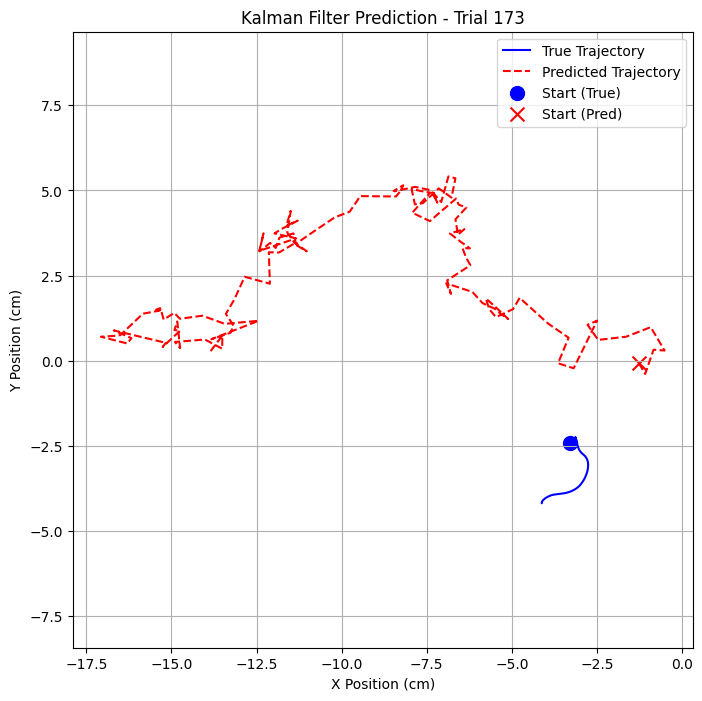

In [17]:

# --- Main Execution ---

if __name__ == "__main__":
    # 1. Load and Preprocess Data
    states, measurements = load_and_preprocess_data(mat_file_path, DELTA_T)

    if states is not None and measurements is not None:
        # 2. Split into Training and Testing Sets
        indices = list(range(len(states)))
        train_indices, test_indices = train_test_split(indices, train_size=TRAIN_TEST_SPLIT_RATIO, random_state=42)

        states_train = [states[i] for i in train_indices]
        measurements_train = [measurements[i] for i in train_indices]
        states_test = [states[i] for i in test_indices]
        measurements_test = [measurements[i] for i in test_indices]

        print(f"\nData split: {len(states_train)} training trials, {len(states_test)} testing trials.")

        # 3. Estimate Kalman Parameters from Training Data
        A, C, Q, R = estimate_kalman_params(states_train, measurements_train, DELTA_T)

        # 4. Run Kalman Filter on Test Data
        # Determine initial state and covariance from training data
        initial_states_train = np.array([s[0, :] for s in states_train]) # State at t=0 for all train trials
        initial_state_mean = np.mean(initial_states_train, axis=0)
        initial_state_cov = np.cov(initial_states_train.T) + np.eye(STATE_DIM) * 1e-6 # Add small value for stability

        print("\nRunning Kalman filter on test trials...")
        predicted_states_list = []
        for i, test_trial_measurements in enumerate(measurements_test):
            print(f"Filtering trial {i+1}/{len(states_test)}...")
            # Use the mean initial state/cov from training data for all test trials
            pred_states, _ = kalman_filter(test_trial_measurements, A, C, Q, R, initial_state_mean, initial_state_cov)
            predicted_states_list.append(pred_states)
        print("Filtering complete.")

        # 5. Evaluate Predictions
        evaluation_metrics = evaluate_predictions(states_test, predicted_states_list)

        # 6. Plot results for a few test trials
        num_trials_to_plot = min(3, len(states_test))
        print(f"\nPlotting trajectories for the first {num_trials_to_plot} test trials...")
        for i in range(num_trials_to_plot):
            plot_trajectory(states_test[i], predicted_states_list[i], test_indices[i]) # Pass original index for title
    else:
        print("\nExiting due to data loading/processing errors.")